In [1]:
import datetime
from pathlib import Path

import geopy.distance
import numpy as np
import obspy
from matplotlib import pyplot as plt
import matplotlib
from numpy.linalg import LinAlgError
from scipy.fft import fft, fftfreq
from tqdm.notebook import tqdm

from utils.physics.bathymetry.bathymetry_grid import BathymetryGrid
from utils.structure.geometry import get_azimuth, distance_point_point

matplotlib.rcParams.update({'font.size': 15})
from scipy.signal import filtfilt, butter, find_peaks, peak_widths
from scipy.ndimage import maximum_filter1d

import pandas as pd

from utils.structure.structure import load_xy_file, Ridge, TransformFault, StructureList
from utils.physics.bathymetry.roughness_grid import RoughnessGrid
from utils.transformations.features_extractor import STFTFeaturesExtractor
from utils.data_reading.catalogs.twin_catalog import TwinCatalog
from utils.data_reading.sound_data.station import StationsCatalog
from utils.physics.sound.sound_velocity_grid import MonthlySoundVelocityGridOptimized
from utils.transformations.signal import butter_bandpass_filter, butter_lowpass_filter, butter_highpass_filter

In [2]:
# input files
isc_dir = f"/home/plerolland/Bureau/catalogs/ISC"
catalog_path = "/media/plerolland/LaBoite/twin_catalog"
datasets_yaml = "/home/plerolland/Bureau/dataset.yaml"

stations = StationsCatalog(datasets_yaml).filter_out_undated().filter_out_unlocated()
sound_model_g = MonthlySoundVelocityGridOptimized([f"../../../data/sound_model/min-velocities_month-{i:02d}.nc" for i in range(1,13)], interpolate=True)
catalog = TwinCatalog(catalog_path, isc_dir, stations)
IDs = list(catalog.items.keys())

bathy_model = BathymetryGrid.create_from_NetCDF("../../../data/geo/GEBCO_2023_sub_ice_topo.nc", lat_bounds=[-75, 60],
                                            lon_bounds=[-20, 180])

roughness_path = "../../../data/geo/roughness/grl60637-sup-0002-2020gl088162-ds01.grd"
roughness_grid = RoughnessGrid.create_from_NetCDF(roughness_path, lat_bounds=[-72,20], lon_bounds=[40,100])

STFT = STFTFeaturesExtractor(None, f_min=0, f_max=240, vmin=60, vmax=140, nperseg=480, overlap=0.75)

DELTA_DISPLAY = datetime.timedelta(seconds=200)
DIST_SAME_EVENT = 111_000  # distance allowed between two events to consider them as a single one (m)
DELTA_SAME_EVENT = datetime.timedelta(minutes=5)  # time allowed between two events to consider them as a single one
np.random.seed(0)

seir = Ridge(load_xy_file("../../../data/structures/axis_seir.xy"), "SEIR")
swir = Ridge(load_xy_file("../../../data/structures/axis_swir.xy")[::-1], "SWIR")  # reversed order (we want RTJ first)
cir = Ridge(load_xy_file("../../../data/structures/axis_cir.xy")[::-1], "CIR")  # reversed order (we want RTJ first)
Macquarie = TransformFault(np.array([(-57, 157), (-47, 165)]), "Macquarie")  # very loosy approximation
structures = StructureList([seir, swir, cir, Macquarie])
sumatra_limit = (-15, 85)  # we consider everything Nort/East of this point as belonging to Sumatra / Java

gcmt = obspy.read_events("/home/plerolland/Bureau/catalogs/GCMT/jan76_dec20.ndk")  # beware : ~4 min of execution
gcmt = gcmt.filter("latitude >= -72", "latitude <= 30", "longitude > 0", "longitude <= 180", "time >= 2010-01-01T00:00", "time <= 2023-01-01T00:00")

res_prefix = "../../../data/T-pick/df"

/home/plerolland/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/plerolland/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


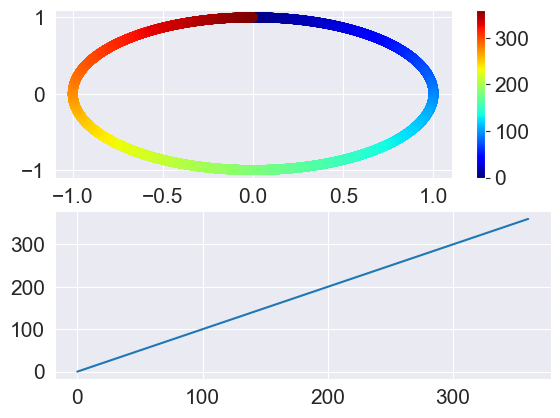

In [3]:
def envelope(data, s_f, cutoff=5e-2):
    m = maximum_filter1d(data, size=s_f)
    return butter_lowpass_filter(m, cutoff, s_f)

def get_width(data, s_f):
    env = envelope(data, s_f)
    peaks = find_peaks(env, height=0, width=0, prominence=0)  
    if len(peaks[0])==0:
        return None, None, None, None
    diff = np.abs(peaks[0]-len(data)//2)
    idx = np.argmin(diff)
    if diff[idx] > s_f*20:
        # the peak is more than 20s away from data center, there is something wrong
        return None, None, None, None
    width, _, left, right = (v[idx] for v in peak_widths(env, peaks[0], rel_height=0.7))
    peak = peaks[0][idx]
    return peak, left, right, env

# test area : generate points on a circle
pts = np.linspace(0, 2*np.pi, 10000)
pts_deg = 180*pts/np.pi
pts_trigo = -pts + np.pi/2
lon = np.cos(pts_trigo)
lat = np.sin(pts_trigo)
r = np.array([get_azimuth((0,0),c) for c in zip(lat, lon)])
r_deg = 180*r/np.pi

# plot computed_azimuth = f(input_azimuth)
# => should be identity
_, axs = plt.subplots(2, 1)
s = axs[0].scatter(lon,lat, c=pts_deg, cmap='jet')
plt.colorbar(s)
axs[1].plot(pts_deg, r_deg)

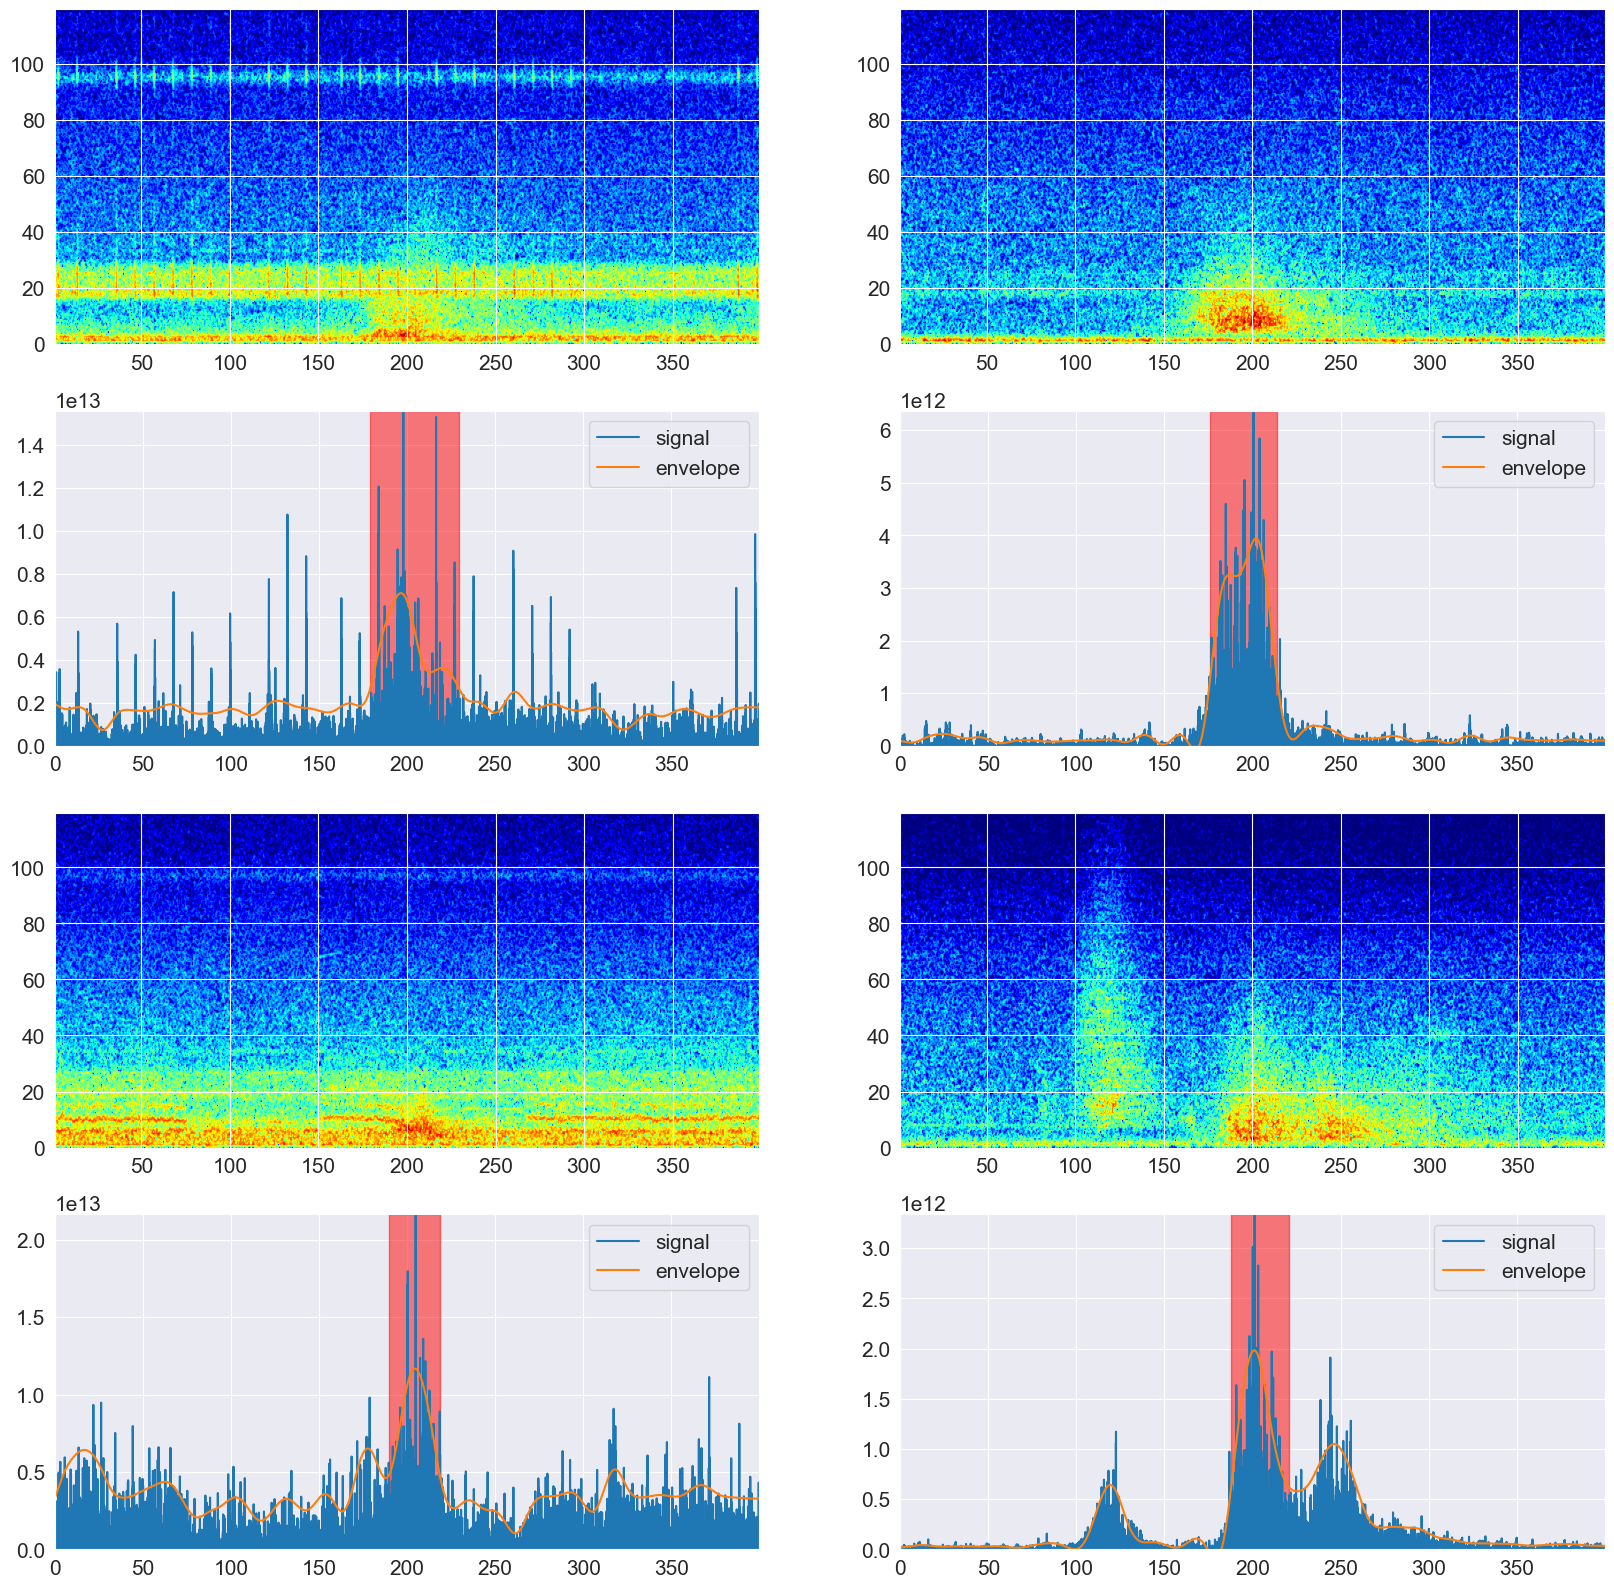

In [4]:
rows = 2
_, axs = plt.subplots(2*rows, 2, figsize=(20,10*rows))

for i in range(rows):
    for j in range(2):
        ID = np.random.choice(IDs)
        event = np.random.choice(catalog.items[ID].acoustic_association.events)
        s_f = 250 if "IMS" in event.station.dataset else 240
        d = int(DELTA_DISPLAY.total_seconds()*s_f)

        data = event.get_data()
        mean_energy = np.mean(np.square(data))
        data = data[len(data)//2-d:len(data)//2+d]

        f, t, spectro = STFT._get_features(data, sf=s_f)
        axs[i*2,j].imshow(spectro, cmap="jet", aspect="auto", extent=(min(t), max(t), min(f), max(f)))

        data = np.square(data) - mean_energy
        data[data < 0] = 0
        s = np.array(range(len(data)))/s_f
        axs[i*2+1,j].plot(s, data, label="signal")

        peak, left, right, env = get_width(data, s_f)
        peak, left, right = peak/s_f, left/s_f, right/s_f
        axs[i*2+1,j].plot(s, env, label="envelope")
        axs[i*2+1,j].axvspan(xmin=left, xmax=right, color='red', alpha=0.5)

        axs[i*2+1,j].set_xlim(0, s[-1])
        axs[i*2+1,j].set_ylim(0, np.max(data))
        axs[i*2+1,j].legend()

## Fill and save the dataframe

In [16]:
columns = ['mb', 'Mw', 'MS', 'strike', 'dip', 'rake', 'roughness', 'structure', 'd_from_structure_m', 'azimuth_from_structure', 'd_along_structure_m', 'delta_loc_m', 'delta_loc_s', 'azimuth_loc', 'date', 'lat', 'lon', 'var_loc_s', 'var_loc_lat', 'var_loc_lon', 'stations', 'travel_time_s', 'distance_m', 'azimuth','duration_s','sum_E','mean_E','peak_E','envelope_peak_E','duration_s_>5','sum_E_>5','mean_E_>5','peak_E_>5','envelope_peak_E_>5','signal_bandwidth','signal_bandwidth_>5', 'max_bathy']
df = pd.DataFrame(columns=columns, index=IDs)
for c in columns[20:]:
    df[c] = [[] for _ in range(len(df))]

discarded = 0

for ID in tqdm(IDs):
    # ISC event part
    isc = catalog.items[ID].isc_event
    mb, Mw, MS = isc.get_magnitude('mb'), isc.get_magnitude('mw'), isc.get_magnitude('ms')
    date, pos = isc.date, isc.get_pos()
    if len(mb)>0:
        df.loc[ID,"mb"] = np.mean(mb)
    if len(Mw)>0:
        df.loc[ID,"Mw"] = np.mean(Mw)
    if len(MS)>0:
        df.loc[ID,"MS"] = np.mean(MS)
    for event in gcmt.events:
        o = event.origins[0]
        if np.abs(o.time.datetime  - date) < DELTA_SAME_EVENT and distance_point_point(pos, (o.latitude,o.longitude)) < DIST_SAME_EVENT:
            # update pos, date
            pos, date = (o.latitude,o.longitude), o.time.datetime
            # update magnitudes
            for magnitude in event.magnitudes:
                if magnitude.magnitude_type=='mb':
                    df.loc[ID,"mb"] = magnitude.mag
                if magnitude.magnitude_type=='Mwc':
                    df.loc[ID,"Mw"] = magnitude.mag
                if magnitude.magnitude_type=='MS':
                    df.loc[ID,"MS"] = magnitude.mag
            # update strike, dip, rake
            fm = event.focal_mechanisms[0].nodal_planes.nodal_plane_1
            df.loc[ID,"strike"], df.loc[ID,"dip"], df.loc[ID,"rake"] = fm.strike, fm.dip, fm.rake
            break
    sensors_positions = np.array([e.station.get_pos() for e in catalog.items[ID].acoustic_association.events])
    detection_times_orig = np.array([e.date for e in catalog.items[ID].acoustic_association.events])
    loc_hydro = sound_model_g.localize_common_source(sensors_positions, detection_times_orig, initial_pos=pos)
    J = loc_hydro.jac
    try:
        cov = np.linalg.inv(J.T.dot(J))
        var = np.sqrt(np.diagonal(cov))
        df.loc[ID,"var_loc_s"] = var[0]
        df.loc[ID,"var_loc_lat"] = var[1]
        df.loc[ID,"var_loc_lon"] = var[2]
    except LinAlgError:
        pass
    date_hydro, loc_hydro = loc_hydro.x[0], loc_hydro.x[1:]
    df.loc[ID,"lat"] = loc_hydro[0]
    df.loc[ID,"lon"] = loc_hydro[1]
    date_hydro = np.min(detection_times_orig) + datetime.timedelta(seconds=date_hydro)
    df.loc[ID,"date"] = date_hydro
    df.loc[ID,"roughness"] = roughness_grid.get_nearest_values(loc_hydro)[0]
    df.loc[ID,"delta_loc_m"] = distance_point_point(loc_hydro, pos)
    df.loc[ID,"delta_loc_s"] = (date_hydro-date).total_seconds()
    df.loc[ID,"azimuth_loc"] = 180*get_azimuth(pos, loc_hydro)/np.pi
    # now use hydroacoustic date and position as "ground truth"
    date, pos = date_hydro, loc_hydro
    if pos[0] > sumatra_limit[0] and pos[1] > sumatra_limit[1]:
        df.loc[ID,"structure"] = "Sumatra"
    else:
        struct_min, point_min, dist_min = structures.get_closest(pos)
        if dist_min < 2*DIST_SAME_EVENT:
            df.loc[ID,"structure"] = struct_min.name
            df.loc[ID,"d_from_structure_m"] = dist_min
            df.loc[ID,"azimuth_from_structure"] = 180*get_azimuth(point_min, pos)/np.pi
            if isinstance(struct_min, Ridge) or isinstance(struct_min, TransformFault):
                df.loc[ID,"d_along_structure_m"] = struct_min.get_distance_from_start(pos)


    # HYDROACOUSTIC PICKS part
    for event in catalog.items[ID].acoustic_association.events:
        s_f = 250 if "IMS" in event.station.dataset else 240
        d = int(DELTA_DISPLAY.total_seconds()*s_f)

        # get data
        data_0 = event.get_data()
        mean_energy = np.mean(np.square(data_0))
        data = data_0[len(data_0)//2-d:len(data_0)//2+d]
        data = np.square(data) - mean_energy
        data[data < 0] = 0
        peak, left, right, env = get_width(data, s_f)
        if peak is None:
            discarded += 1
            continue  # no peak : something was wrong (e.g. STA/LTA < 1)
        left, right = int(left), int(right)
        data, env = data[left:right], env[left:right]
        if np.max(data)==0:
            discarded += 1
            continue
        data_fft_freq = fftfreq(len(data), 1/s_f)[:len(data) // 2]
        data_fft = (np.abs(fft(data)) ** 2)[:len(data) // 2]
        cum_sum = np.cumsum(data_fft) / sum(data_fft)
        signal_height = data_fft_freq[cum_sum>1/3][0]

        # get data > 5 Hz
        data_5 = butter_highpass_filter(data_0, 5, s_f)
        mean_energy_5 = np.mean(np.square(data_5))
        data_5 = data_5[len(data_5)//2-d:len(data_5)//2+d]
        data_5 = np.square(data_5) - mean_energy_5
        data_5[data_5 < 0] = 0
        peak_5, left_5, right_5, env_5 = get_width(data_5, s_f)
        if peak_5 is None:
            discarded += 1
            continue  # no peak : something was wrong (e.g. STA/LTA < 1)
        left_5, right_5 = int(left_5), int(right_5)
        data_5, env_5 = data_5[left_5:right_5], env_5[left_5:right_5]
        if np.max(data_5)==0:
            discarded += 1
            continue
        data_fft_freq_5 = fftfreq(len(data_5), 1/s_f)[:len(data_5) // 2]
        data_fft_5 = (np.abs(fft(data_5)) ** 2)[:len(data_5) // 2]
        cum_sum_5 = np.cumsum(data_fft_5) / sum(data_fft_5)
        signal_height_5 = data_fft_freq_5[cum_sum_5>1/3][0]

        df.loc[ID]["stations"].append(f"{event.station.name}-{event.station.date_start.year}")
        df.loc[ID]["travel_time_s"].append((event.date - date).total_seconds())
        df.loc[ID]["distance_m"].append(distance_point_point(pos, event.get_pos()))
        df.loc[ID]["azimuth"].append(180*get_azimuth(pos, event.get_pos())/np.pi)
        df.loc[ID]["duration_s"].append((right-left)/s_f)
        df.loc[ID]["sum_E"].append(np.sum(data))
        df.loc[ID]["mean_E"].append(np.mean(data))
        df.loc[ID]["peak_E"].append(np.max(data))
        df.loc[ID]["envelope_peak_E"].append(np.max(env))
        df.loc[ID]["duration_s_>5"].append((right_5-left_5)/s_f)
        df.loc[ID]["sum_E_>5"].append(np.sum(data_5))
        df.loc[ID]["mean_E_>5"].append(np.mean(data_5))
        df.loc[ID]["peak_E_>5"].append(np.max(data_5))
        df.loc[ID]["envelope_peak_E_>5"].append(np.max(env_5))
        df.loc[ID]["signal_bandwidth"].append(signal_height)
        df.loc[ID]["signal_bandwidth_>5"].append(signal_height_5)
        try:
            df.loc[ID]["max_bathy"].append(np.max(bathy_model.get_along_path_nearest(pos, event.get_pos())[0]))
        except AssertionError:
            df.loc[ID]["max_bathy"].append(np.nan)

        event.data = None  # flush the data when it is not needed anymore to avoid a memory leak
        
df.to_pickle(f"{res_prefix}.pkl")
df.to_csv(f"{res_prefix}.csv")


print(f"Done ! {discarded} picks have been discarded because there were no clear peaks")

  0%|          | 0/10134 [00:00<?, ?it/s]

/tmp/ipykernel_352389/1633881188.py:42: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.diagonal(cov))


Done ! 279 picks have been discarded because there were no clear peaks


## Make spectrograms from detections

In [3]:
DELTA_spectro = 100
TIME_RES = 0.5
F_RES = 0.5

for ID in tqdm(IDs):
    path = f"/media/plerolland/LaBoite/T-pick/{ID}"
    Path(path).mkdir(parents=True, exist_ok=True)
    for event in catalog.items[ID].acoustic_association.events:
        f = f"{path}/{event.station.name}.png"
        if Path(f).exists():
            continue
        s_f = 250 if "IMS" in event.station.dataset else 240
        delta_spectro = DELTA_spectro * s_f
        STFT.nperseg = int(s_f / F_RES)
        STFT.overlap = 1 - TIME_RES * s_f / STFT.nperseg
        
        
        data_0 = event.get_data()
        data_0 = data_0[len(data_0)//2-delta_spectro:len(data_0)//2+delta_spectro]
        features = STFT._get_features(data_0, sf=s_f)
        STFT._save_features(features, f)
        event.data = None

  0%|          | 0/10134 [00:00<?, ?it/s]

## Make raw waveforms from detections

In [5]:
DELTA_spectro = 100

for ID in tqdm(IDs):
    path = f"/media/plerolland/LaBoite/T-pick/{ID}"
    Path(path).mkdir(parents=True, exist_ok=True)
    for event in catalog.items[ID].acoustic_association.events:
        f = f"{path}/{event.station.name}.npy"
        if Path(f).exists():
            continue
        s_f = 250 if "IMS" in event.station.dataset else 240
        delta_spectro = DELTA_spectro * s_f
        
        data = event.get_data()
        data = data[len(data)//2-delta_spectro:len(data)//2+delta_spectro]
        
        idx_250 = np.linspace(0, 2*DELTA_spectro, 250*2*DELTA_spectro)
        idx_actual = np.linspace(0, 2*DELTA_spectro, len(data))
        data = np.interp(idx_250, idx_actual, data)
        
        np.save(f, data)
        event.data = None

  0%|          | 0/10134 [00:00<?, ?it/s]